In [1]:
%pip install pandas
%pip install pymongo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pyspark
from pyspark.sql import SparkSession
from pymongo import MongoClient
import pandas as pd

# Crea una SparkSession
spark = SparkSession.builder \
    .appName("MongoSparkConnector") \
    .getOrCreate()

# Conecta a MongoDB usando pymongo
client = MongoClient("mongodb://172.17.0.3:27017/")
db = client['docker']
collection = db['yt-data']

# Extrae los datos desde MongoDB
mongo_data = list(collection.find())

#print(mongo_data)

# Convierte los datos a un DataFrame de pandas
pdf = pd.DataFrame(mongo_data)


# Reemplazar la coma por un punto en la columna 'visualizaciones'
pdf['views'] = pdf['views'].str.replace(',', '.')

# Definir una función que limpie y transforme los valores de la columna
def transformar_visualizaciones(valor):
    # Obtener la parte numérica y el sufijo
    num, sufijo = valor.split(' ')[0], valor.split(' ')[1]
    
    # Transformar el valor basado en el sufijo
    if sufijo == 'M':
        return str(float(num) * 1e6).replace('.0', '')  # Multiplicar por 1 millón y convertir a string
    if sufijo == 'K':
        return str(float(num) * 1e3).replace('.0', '')  # Multiplicar por mil y convertir a string
    else:
        return num  # En caso de que haya otros sufijos en el futuro

# Aplicar la función a la columna
pdf['views'] = pdf['views'].apply(transformar_visualizaciones)

pdf['views'] = pdf['views'].astype(float)

# Definir una función que limpie y transforme los valores de la columna
def transformar_anio(valor):
    # Obtener la parte numérica y el sufijo
    num, tiempo = valor.split(' ')[1], valor.split(' ')[2]
    
    # Transformar el valor basado en el sufijo
    if tiempo == 'años' or tiempo == 'año':
        return num 
    if tiempo == 'semanas' or tiempo == 'semana':
       return 0
    if tiempo == 'meses' or tiempo == 'mes':
        return 0
    else:
        return num 

# Aplicar la función a la columna

pdf['fecha_anio'] = pdf['fecha'].apply(transformar_anio)

# Elimina la columna '_id' si es necesario, ya que no es serializable por defecto en Spark
if '_id' in pdf.columns:
    pdf = pdf.drop(columns=['_id'])

# Convierte el DataFrame de pandas a un DataFrame de Spark
df = spark.createDataFrame(pdf)

# Convertir el DataFrame a un RDD
rdd = df.select("user", "views").rdd

# Convertir el DataFrame a un RDD
rdd = df.select("user", "views", "fecha_anio").rdd

# Usar map y reduceByKey para contar las visitas por usuario y año
user_year_views_rdd = rdd.map(lambda row: ((row['user'], row['fecha_anio']), row['views'])) \
                         .reduceByKey(lambda a, b: a + b)

# Convertir el RDD de nuevo a un DataFrame
user_year_views_df = user_year_views_rdd.map(lambda x: (x[0][0], x[0][1], x[1])) \
                                        .toDF(["user", "fecha_anio", "total_views"])

#user_year_views_df = user_year_views_df.sort_values(by='fecha_anio')
# Mostrar los resultados
user_year_views_df.show()

df0 = user_year_views_df.toPandas()

print(pdf)


+----------------+----------+-----------+
|            user|fecha_anio|total_views|
+----------------+----------+-----------+
|    @amaiaromero|         4|  5500000.0|
|@ClaudiaNicolasa|         5|   288500.0|
|@ClaudiaNicolasa|         2|  7635000.0|
|    @amaiaromero|         0|   393000.0|
|    @amaiaromero|         3|   616000.0|
|@ClaudiaNicolasa|         3|  5241100.0|
|    @amaiaromero|         5|   1.0309E7|
|@ClaudiaNicolasa|         4|  2627800.0|
|    @amaiaromero|         2|  9125000.0|
|@ClaudiaNicolasa|         1|  8816700.0|
| @belen_aguilera|         4|  5493000.0|
| @belen_aguilera|         5|  5592000.0|
| @belen_aguilera|         0|  1224000.0|
| @belen_aguilera|         3|   1.0323E7|
| @belen_aguilera|         1|  2701000.0|
| @belen_aguilera|         2|  9655200.0|
|@ClaudiaNicolasa|         0|  6246800.0|
+----------------+----------+-----------+

                                                titulo      views  \
0                                        Amaia -

In [17]:
def transformar_anio2000(valor):
    if valor == '0':
        return 2024 
    if valor == '1':
       return 2023
    if valor == '2':
        return 2022
    if valor == '3':
        return 2021
    if valor == '4':
        return 2020
    if valor == '5':
        return 2019
    else:
        return valor 

# Aplicar la función a la columna

df0['fecha_anio'] = df0['fecha_anio'].apply(transformar_anio2000)

anios = [2019, 2020,2021,2022,2023]

df0_claudia = df0[(df0['user'] == '@ClaudiaNicolasa') & (df0['fecha_anio'].isin(anios))]

df0_claudia.sort_values(by='fecha_anio', inplace=True)

print(df0_claudia)

               user  fecha_anio  total_views
1  @ClaudiaNicolasa        2019     288500.0
7  @ClaudiaNicolasa        2020    2627800.0
5  @ClaudiaNicolasa        2021    5241100.0
2  @ClaudiaNicolasa        2022    7635000.0
9  @ClaudiaNicolasa        2023    8816700.0


/tmp/ipykernel_14936/3086656514.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0_claudia.sort_values(by='fecha_anio', inplace=True)


Mean Squared Error: 845835677550.9863
R-squared: 0.9116677973160596
Intercepto: -4951816400.0
Coeficiente: [2452757.14285714]


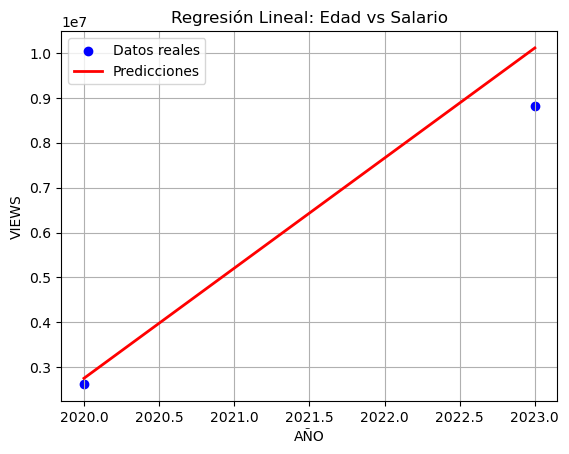

In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Seleccionar las características (X) y el objetivo (y)
X = df0_claudia[['fecha_anio']]
y = df0_claudia['total_views']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Crear el modelo de regresión lineal
modelo = LinearRegression()

# Entrenar el modelo
modelo.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Mostrar los coeficientes del modelo
print("Intercepto:", modelo.intercept_)
print("Coeficiente:", modelo.coef_)

# Graficar los resultados
plt.scatter(X_test, y_test, color='blue', label='Datos reales')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicciones')
plt.xlabel('AÑO')
plt.ylabel('VIEWS')
plt.title('Regresión Lineal: Edad vs Salario')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
import numpy as np

anio_2025 = np.array([[2025]])
prediccion_2025 = modelo.predict(anio_2025)
print("Predicción para el año 2025:", prediccion_2025[0])

Predicción para el año 2025: 15016814.28571415


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
